In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import datetime

In [2]:
train = pd.read_csv('train.csv')
gas_df = pd.read_csv('gas_prices.csv')
electricity_df = pd.read_csv('electricity_prices.csv')
client_df = pd.read_csv('client.csv')
fw_df = pd.read_csv('forecast_weather.csv')
hw_df = pd.read_csv('historical_weather.csv')
locations = pd.read_csv('county_lon_lats.csv')

In [3]:
def TrainPreprocessing(train, client_df, fw_df, electricity_df, gas_df, locations, hw_df):
    '''Train data preprocessing'''
    
    # Drop nan values
    train = train[train['target'].notnull()]
    
    # Converting to datetime & date feature engineering
    train['datetime'] = pd.to_datetime(train['datetime'], utc=True)
    
    train['year'] = train['datetime'].dt.year
    train['quarter'] = train['datetime'].dt.quarter
    train['month'] = train['datetime'].dt.month
    train['week'] = train['datetime'].dt.isocalendar().week
    train['day'] = train['datetime'].dt.day
    train['hour'] = train['datetime'].dt.hour
    train['dayofweek'] = train['datetime'].dt.dayofweek
    train['dayofyear'] = train['datetime'].dt.dayofyear

    
    # Client data processing
    # Subtracting 2 from data_block_id. Data is two steps ahead
    client_df['data_block_id'] -= 2
    
    # Average installed capacity. (installed_capacity / eic_count)
    client_df['avg_installed_cap'] = client_df['installed_capacity'] / client_df['eic_count']

    
    # Electricity data processing
    # Renaming (forecast_date) to (datetime) for merging with the train data later
    electricity_df = electricity_df.rename(columns= {'forecast_date' : 'datetime'})
    
    # Converting (datetime) column to datetime
    electricity_df['datetime'] = pd.to_datetime(electricity_df['datetime'], utc= True)
    
    electricity_df['hour'] = electricity_df['datetime'].dt.hour
    
    # Locations data processing
    # Drop
    locations = locations.drop('Unnamed: 0', axis= 1) 
        

    # Forecast Weather 
    # 1. Rounding lat & lon to 1 decimal place
    # 2. Merge counties data from locations DF to lat & lon in forecast weather df
    # 3. Drop null rows
    # 4. Convert county col to int dtype
    # 5. Drop un-necessary columns
    # 6. Rename date column to 'datetime' and convert to datetime dtype
    # 7. New df with mean weather values per hour. Convert datetime back to normal datetime format in new df.
    # 8. New df with mean values per hour grouped also by county. Convert datetime col back to datetime.
    
    # 1.
    fw_df[['latitude', 'longitude']] = fw_df[['latitude', 'longitude']].astype(float).round(1)
    
    # 2.
    fw_df = fw_df.merge(locations, how='left', on=['latitude', 'longitude'])
    
    # 3.
    fw_df.dropna(axis=0, inplace=True)
    
    # 4.
    fw_df['county'] = fw_df['county'].astype('int64')
    
    # 5.
    fw_df.drop(['origin_datetime', 'latitude', 'longitude', 'hours_ahead',
               'data_block_id'], axis=1, inplace=True)
    
    # 6.
    fw_df.rename(columns={'forecast_datetime': 'datetime'}, inplace=True)
    fw_df['datetime'] = pd.to_datetime(fw_df['datetime'], utc=True)
    
    # 7.
    fw_df_mean = fw_df.groupby([fw_df['datetime']
                                .dt.to_period('h')])[list(fw_df.drop(['county', 'datetime'], axis=1)
                                                                           .columns)].mean().reset_index()
    fw_df_mean['datetime'] = pd.to_datetime(fw_df_mean['datetime'].dt.to_timestamp(), utc=True)
    
    # 8. 
    fw_df_county = fw_df.groupby(['county', fw_df['datetime'].dt.to_period('h')])[list(fw_df.drop(['county', 'datetime'], axis=1).columns)].mean().reset_index()
    fw_df_county['datetime'] = pd.to_datetime(fw_df_county['datetime'].dt.to_timestamp(), utc=True)

    
    # Historical weather df processing
    # 1. Rounding lat & lon to 1 decimal place
    # 2. Merge counties data from locations DF to lat & lon in forecast weather df
    # 3. Drop null rows
    # 4. Convert county col to int dtype
    # 5. Drop un-necessary columns
    # 6. Rename date column to 'datetime' and convert to datetime dtype
    # 7. New df with mean weather values per hour. Convert datetime back to normal datetime format in new df.
    # 8. New df with mean values per hour grouped also by county. Convert datetime col back to datetime.
    # 9. Merge data_block_id back to new county df
   
    # 1.
    hw_df[['latitude', 'longitude']] = hw_df[['latitude', 'longitude']].astype(float).round(1)
    
    # 2.
    hw_df = hw_df.merge(locations, how='left', on=['longitude', 'latitude'])
    
    # 3.
    hw_df.dropna(axis=0, inplace=True)
    
    # 4.
    hw_df['county'] = hw_df['county'].astype('int64')
    
    # 5.
    hw_df.drop(['latitude', 'longitude'], axis=1, inplace=True)
    
    # 6.
    hw_df['datetime'] = pd.to_datetime(hw_df['datetime'], utc=True)
    
    # 7.
    hw_df_mean = hw_df.groupby([hw_df['datetime']
                                .dt.to_period('h')])[list(hw_df.drop(['county', 'datetime', 'data_block_id'], axis=1)
                                                                           .columns)].mean().reset_index()
    hw_df_mean['datetime'] = pd.to_datetime(hw_df_mean['datetime'].dt.to_timestamp(), utc=True)
    
    hw_df_mean = hw_df_mean.merge(hw_df[['datetime', 'data_block_id']], how='left', on='datetime')
    
    # 8. 
    hw_df_county = hw_df.groupby(['county', hw_df['datetime'].dt.to_period('h')])[list(hw_df.drop(['county', 'datetime', 'data_block_id'], axis=1).columns)].mean().reset_index()
    hw_df_county['datetime'] = pd.to_datetime(hw_df_county['datetime'].dt.to_timestamp(), utc=True)
    hw_df_county = hw_df_county.merge(hw_df[['datetime', 'data_block_id']], how='left', on='datetime')
    hw_df_county.drop_duplicates(inplace=True)
    hw_df_county.reset_index()
    
    # Merge the data into train set
    # 1. Merge client 
    # 2. Merge gas
    # 3. Merge electricity
    # 4. Merge forecast weather
    # 5. Merge forecast weather by county
    # 6. Add hour col to hist weather and hist county. Drop dups and datetime col
    # 7. Merge hist weather menas
    # 8. Merge hist weather means by county
    # 9. Fill null values with forward and backward method
    # 10. Drop un-necessary cols...?

    
    # 1
    train = train.merge(client_df.drop(columns = ['date']), how='left', on = ['data_block_id', 'county', 'is_business', 'product_type'])
    
    # 2
    train = train.merge(gas_df[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    # 3
    train = train.merge(electricity_df[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour','data_block_id'])
    
    # 4 
    train = train.merge(fw_df_mean, how='left', on='datetime')
    
    # 5 
    train = train.merge(fw_df_county, how='left', on=['datetime', 'county'], suffixes = ('_fcast_mean', '_fcast_mean_by_county'))
    
    # 6
    hw_df_mean['hour'] = hw_df_mean['datetime'].dt.hour
    hw_df_county['hour'] = hw_df_county['datetime'].dt.hour
    
    hw_df_mean.drop_duplicates(inplace=True)
    hw_df_county.drop_duplicates(inplace=True)
    hw_df_mean.drop('datetime', axis=1, inplace=True)
    hw_df_county.drop('datetime', axis=1, inplace=True)

    # 7
    train = train.merge(hw_df_mean, how='left', on=['data_block_id', 'hour'])
    
    # 8 
    train = train.merge(hw_df_county, how='left', on=['data_block_id', 'county', 'hour'], suffixes= ('_hist_mean', '_hist_mean_by_county'))
    
    # 9
    train = train.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill().reset_index())
    
    # 10
    train.drop(['row_id', 'data_block_id'], axis = 1, inplace = True)
    
    return train

In [4]:
def is_holiday(dataframe):
    '''Creates is_holiday boolean column for Estonian country wide holidays'''
    estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2024))
    estonian_holidays = list(estonian_holidays.keys())

    
    dataframe['is_holiday'] = dataframe.apply(lambda row: (datetime.date(row['year'], row['month'], row['day']) in estonian_holidays) * 1, axis=1)
    return dataframe

In [5]:
def create_target_lags(train, N_lags):
    '''Lag target variables are a form of feature engineering that gives
    the model context for what the target was N days ago'''
    
    # Store datetime column in a python object
    og_datetime = train['datetime']
    
    # Store important variables to reference with target
    target_and_friends = train[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    # Create lagged targets
    for lag in range(2, N_lags + 1): # Starts at 2, ends at set day
        target_and_friends['datetime'] = og_datetime + pd.DateOffset(lag) # Shifts dates forward by set amount (lag)
        train = train.merge(target_and_friends, how='left', on=['datetime', 'prediction_unit_id', 'is_consumption'], suffixes = ('', f'_{lag}_days_ago'))
        
    return train

In [6]:
# Train preprocessing
train = TrainPreprocessing(train, client_df, fw_df, electricity_df, gas_df, locations, hw_df)

# Add holidays
train = is_holiday(train)

# Add target lags
N_lags = 7
train = create_target_lags(train, N_lags) #Any number after 2
train.head()

/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_11098/1136655979.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['datetime'] = pd.to_datetime(train['datetime'], utc=True)
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_11098/1136655979.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['year'] = train['datetime'].dt.year
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_11098/1136655979.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,index,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,year,quarter,...,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county,is_holiday,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago
0,0,0,0,1,0.713,0,2021-09-01 00:00:00+00:00,0,2021,3,...,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,96.590,1,2021-09-01 00:00:00+00:00,0,2021,3,...,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,2,0.000,0,2021-09-01 00:00:00+00:00,1,2021,3,...,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,2,17.314,1,2021-09-01 00:00:00+00:00,1,2021,3,...,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,0,3,2.904,0,2021-09-01 00:00:00+00:00,2,2021,3,...,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Drop year column as its no longer needed
train.drop(['year'], axis=1, inplace=True)

In [8]:
# Further feature engineering

# Convert datetime to integer for date features
train['datetime'] = train['datetime'].astype('int64')

train['sin_hour']= (np.pi * np.sin(train['hour']) / 12)
train['cos_hour']= (np.pi * np.cos(train['hour']) / 12)
train['sin_dayofyear']= (np.pi * np.sin(train['dayofyear']) / 183)
train['cos_dayofyear']= (np.pi * np.cos(train['dayofyear']) / 183)
train['target_mean']= train[[f'target_{i}_days_ago' for i in range(2, N_lags+1)]].mean(1)
train['target_std']= train[[f'target_{i}_days_ago' for i in range(2, N_lags+1)]].std(1)
train['target_var']= train[[f'target_{i}_days_ago' for i in range(2, N_lags+1)]].var(1)


In [9]:
train.columns

Index(['index', 'county', 'is_business', 'product_type', 'target',
       'is_consumption', 'datetime', 'prediction_unit_id', 'quarter', 'month',
       'week', 'day', 'hour', 'dayofweek', 'dayofyear', 'eic_count',
       'installed_capacity', 'avg_installed_cap', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'euros_per_mwh', 'temperature_fcast_mean',
       'dewpoint_fcast_mean', 'cloudcover_high_fcast_mean',
       'cloudcover_low_fcast_mean', 'cloudcover_mid_fcast_mean',
       'cloudcover_total_fcast_mean', '10_metre_u_wind_component_fcast_mean',
       '10_metre_v_wind_component_fcast_mean',
       'direct_solar_radiation_fcast_mean',
       'surface_solar_radiation_downwards_fcast_mean', 'snowfall_fcast_mean',
       'total_precipitation_fcast_mean', 'temperature_fcast_mean_by_county',
       'dewpoint_fcast_mean_by_county', 'cloudcover_high_fcast_mean_by_county',
       'cloudcover_low_fcast_mean_by_county',
       'cloudcover_mid_fcast_mean_by_county',
       'cloudco

In [10]:
# Log columns with outliers
to_log= ['installed_capacity', 'euros_per_mwh', 'temperature_fcast_mean', 'dewpoint_fcast_mean',
        'cloudcover_high_fcast_mean', 'cloudcover_low_fcast_mean', 'cloudcover_mid_fcast_mean', 'cloudcover_total_fcast_mean',
        '10_metre_u_wind_component_fcast_mean', '10_metre_v_wind_component_fcast_mean', 'direct_solar_radiation_fcast_mean',
        'snowfall_fcast_mean', 'total_precipitation_fcast_mean', 'temperature_fcast_mean_by_county', 'dewpoint_fcast_mean_by_county',
        'cloudcover_high_fcast_mean_by_county', 'cloudcover_low_fcast_mean_by_county', 'cloudcover_mid_fcast_mean_by_county',
        'cloudcover_total_fcast_mean_by_county', '10_metre_u_wind_component_fcast_mean_by_county', '10_metre_v_wind_component_fcast_mean_by_county',
        'surface_solar_radiation_downwards_fcast_mean_by_county', 'snowfall_fcast_mean_by_county', 'total_precipitation_fcast_mean_by_county',
        'rain_hist_mean', 'snowfall_hist_mean', 'windspeed_10m_hist_mean_by_county', 'target_2_days_ago', 'target_3_days_ago',
        'target_4_days_ago', 'target_5_days_ago', 'target_6_days_ago', 'target_7_days_ago', 'target_mean', 'target_std']
for i in to_log:
    train[f"log_{i}"]= np.where((train[i])!= 0, np.log(train[i]),0) #Create new col and log the value if not 0


# , 'target_8_days_ago', 'target_9_days_ago', 'target_10_days_ago', 'target_11_days_ago', 'target_12_days_ago', 'target_13_days_ago', 'target_14_days_ago', 'target_15_days_ago'

/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*i

In [11]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017824 entries, 0 to 2017823
Data columns (total 122 columns):
 #    Column                                                      Dtype  
---   ------                                                      -----  
 0    index                                                       int64  
 1    county                                                      int64  
 2    is_business                                                 int64  
 3    product_type                                                int64  
 4    target                                                      float64
 5    is_consumption                                              int64  
 6    datetime                                                    int64  
 7    prediction_unit_id                                          int64  
 8    quarter                                                     int64  
 9    month                                                       int64 

In [12]:
#train.drop('datetime', axis=1, inplace=True)


In [13]:
pd.set_option('display.max_columns', None)

In [14]:
train.head()

,index,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,quarter,month,week,day,hour,dayofweek,dayofyear,eic_count,installed_capacity,avg_installed_cap,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,temperature_fcast_mean,dewpoint_fcast_mean,cloudcover_high_fcast_mean,cloudcover_low_fcast_mean,cloudcover_mid_fcast_mean,cloudcover_total_fcast_mean,10_metre_u_wind_component_fcast_mean,10_metre_v_wind_component_fcast_mean,direct_solar_radiation_fcast_mean,surface_solar_radiation_downwards_fcast_mean,snowfall_fcast_mean,total_precipitation_fcast_mean,temperature_fcast_mean_by_county,dewpoint_fcast_mean_by_county,cloudcover_high_fcast_mean_by_county,cloudcover_low_fcast_mean_by_county,cloudcover_mid_fcast_mean_by_county,cloudcover_total_fcast_mean_by_county,10_metre_u_wind_component_fcast_mean_by_county,10_metre_v_wind_component_fcast_mean_by_county,direct_solar_radiation_fcast_mean_by_county,surface_solar_radiation_downwards_fcast_mean_by_county,snowfall_fcast_mean_by_county,total_precipitation_fcast_mean_by_county,temperature_hist_mean,dewpoint_hist_mean,rain_hist_mean,snowfall_hist_mean,surface_pressure_hist_mean,cloudcover_total_hist_mean,cloudcover_low_hist_mean,cloudcover_mid_hist_mean,cloudcover_high_hist_mean,windspeed_10m_hist_mean,winddirection_10m_hist_mean,shortwave_radiation_hist_mean,direct_solar_radiation_hist_mean,diffuse_radiation_hist_mean,temperature_hist_mean_by_county,dewpoint_hist_mean_by_county,rain_hist_mean_by_county,snowfall_hist_mean_by_county,surface_pressure_hist_mean_by_county,cloudcover_total_hist_mean_by_county,cloudcover_low_hist_mean_by_county,cloudcover_mid_hist_mean_by_county,cloudcover_high_hist_mean_by_county,windspeed_10m_hist_mean_by_county,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county,is_holiday,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago,sin_hour,cos_hour,sin_dayofyear,cos_dayofyear,target_mean,target_std,target_var,log_installed_capacity,log_euros_per_mwh,log_temperature_fcast_mean,log_dewpoint_fcast_mean,log_cloudcover_high_fcast_mean,log_cloudcover_low_fcast_mean,log_cloudcover_mid_fcast_mean,log_cloudcover_total_fcast_mean,log_10_metre_u_wind_component_fcast_mean,log_10_metre_v_wind_component_fcast_mean,log_direct_solar_radiation_fcast_mean,log_snowfall_fcast_mean,log_total_precipitation_fcast_mean,log_temperature_fcast_mean_by_county,log_dewpoint_fcast_mean_by_county,log_cloudcover_high_fcast_mean_by_county,log_cloudcover_low_fcast_mean_by_county,log_cloudcover_mid_fcast_mean_by_county,log_cloudcover_total_fcast_mean_by_county,log_10_metre_u_wind_component_fcast_mean_by_county,log_10_metre_v_wind_component_fcast_mean_by_county,log_surface_solar_radiation_downwards_fcast_mean_by_county,log_snowfall_fcast_mean_by_county,log_total_precipitation_fcast_mean_by_county,log_rain_hist_mean,log_snowfall_hist_mean,log_windspeed_10m_hist_mean_by_county,log_target_2_days_ago,log_target_3_days_ago,log_target_4_days_ago,log_target_5_days_ago,log_target_6_days_ago,log_target_7_days_ago,log_target_mean,log_target_std
0,0,0,0,1,0.713,0,1630454400000000000,0,3,9,35,1,0,2,244,108.0,952.89,8.823056,50.15,69.99,71.36,13.014066,10.531545,0.256954,0.213331,0.069662,0.438023,1.970332,-5.205125,0.0,0.0,0.0,0.0,13.279187,10.265674,0.19263,0.036087,0.005286,0.215636,2.511035,-5.096591,0.0,0.0,0.0,0.0,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.261799,-0.014842,0.008628,NaN,NaN,NaN,6.859499,4.267737,2.566031,2.354375,-1.358858,-1.544909,-2.664093,-0.825485,0.678202,NaN,0.0,0.0,0.0,2.586198,2.328806,-1.646984,-3.321822,-5.242761,-1.534165,0.920695,NaN,0.0,0.0,0.0,0.0,0.0,1.427783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,96.590,1,1

In [15]:
import dask.dataframe as dd

# Convert pandas DataFrame to Dask DataFrame
dask_df = dd.from_pandas(train, npartitions=5)

# Separate features and target variable
X = dask_df.drop('target', axis = 1)
y = dask_df['target']

# Split data into train and test sets
X_train, X_test = X.random_split([0.8, 0.2], random_state=42)
y_train, y_test = y.random_split([0.8, 0.2], random_state=42)

# # Separate production targets into a separate train and test set for a second model
# X_prod = dask_df[dask_df['is_consumption'] == 0].drop('target', axis = 1)
# y_prod = dask_df[dask_df['is_consumption'] == 0]['target']

# # Split production targets into train and test sets
# X_prod_train, X_prod_test = X_prod.random_split([0.8, 0.2], random_state=42)
# y_prod_train, y_prod_test = y_prod.random_split([0.8, 0.2], random_state=42)

/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [39]:
from sklearn.model_selection import train_test_split
# Splitting data into train and test set numpy arrays
X = train.drop('target', axis = 1).values
y = train['target'].values
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Seperating production targets into a seperate train and test set for a second model
# X_prod = train[train['is_consumption'] == 0].drop('target', axis = 1).values
# y_prod = train[train['is_consumption'] == 0]['target'].values

# # Splitting production targets into train and test sets
# X_prod_train, X_prod_test, y_prod_train, y_prod_test = train_test_split(X_prod, y_prod, test_size=0.2, random_state=42)


In [18]:
# import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Baseline Models

# linear = LinearRegression()
# scores = cross_val_score(linear, X, y)
# scores = cross_val_score(linear, X, y, scoring="neg_mean_squared_error")

# forest = RandomForestRegressor()
# scores = cross_val_score(forest, X, y)
# scores = cross_val_score(forest, X, y, scoring="neg_mean_squared_error")

lgbm = lgb.LGBMRegressor(force_row_wise = True, verbose=-1)
scores = cross_val_score(lgbm, X, y)
scores = cross_val_score(lgbm, X, y, scoring="neg_mean_squared_error")


[-20565.44907748 -21061.84028693 -18787.71076136 -29155.04483762
 -38385.89299893]


In [16]:
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm as lgb

model = lgb.LGBMRegressor(force_row_wise=True, verbose = -1)
model = model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Print the accuracy
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 43.9331231101866


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

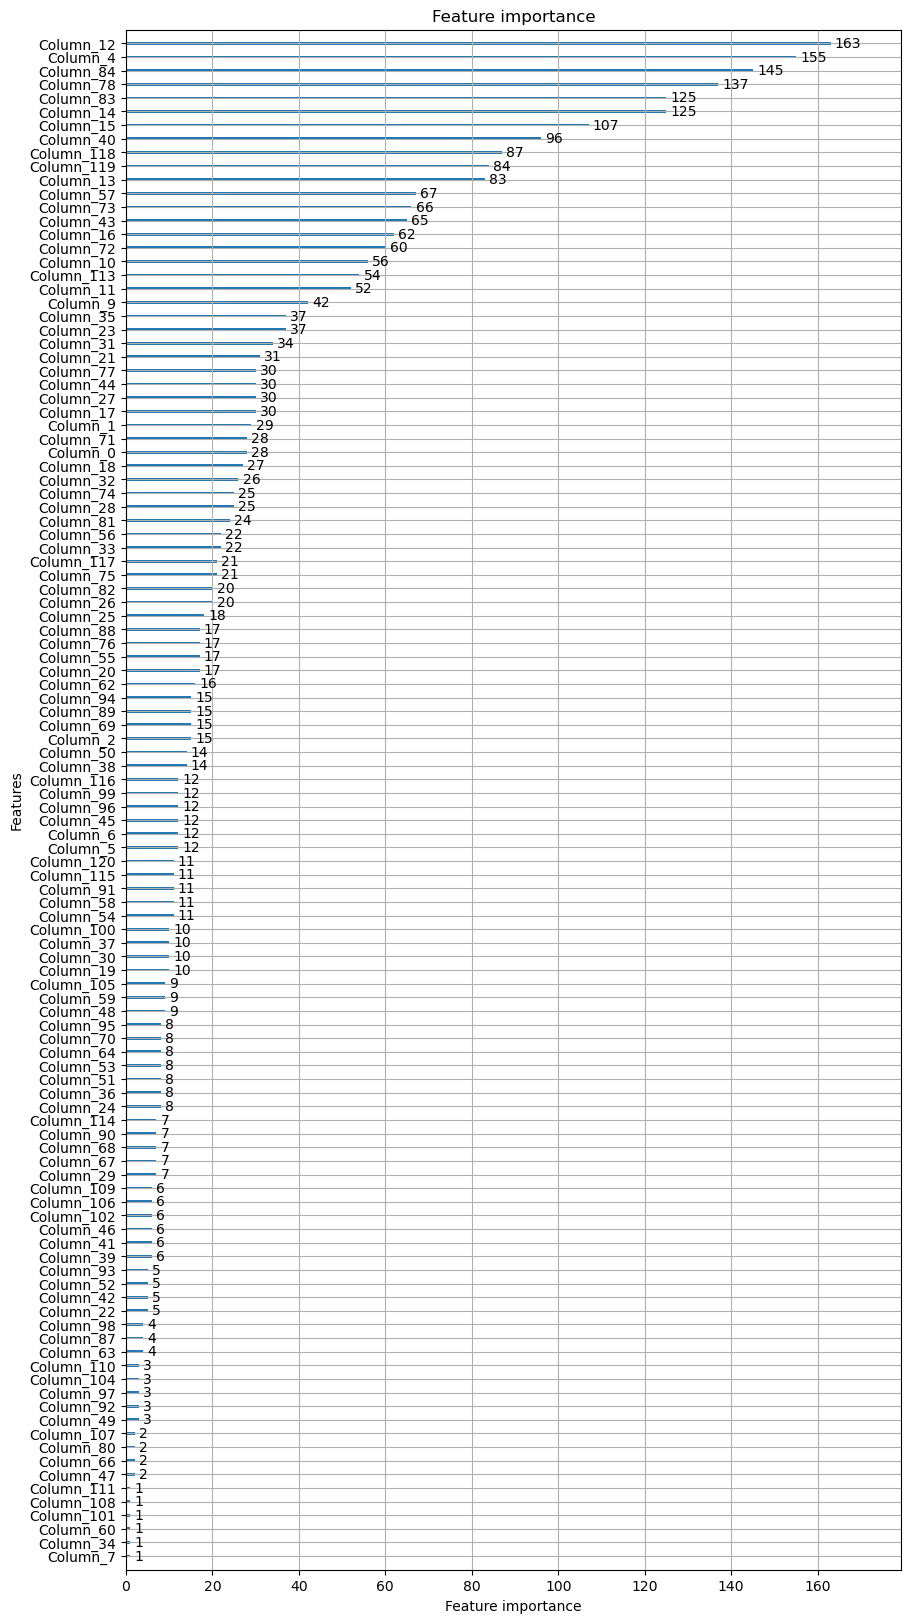

In [17]:

ax = lgb.plot_importance(model)
fig = plt.gcf()
fig.set_size_inches(10, 20)
ax